/Users/skinnej3/anaconda/lib/python3.5/site-packages/emcee-2.1.0-py3.5.egg/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
/Users/skinnej3/anaconda/lib/python3.5/site-packages/emcee-2.1.0-py3.5.egg/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater


Completed in  0  minutes and  25 seconds.


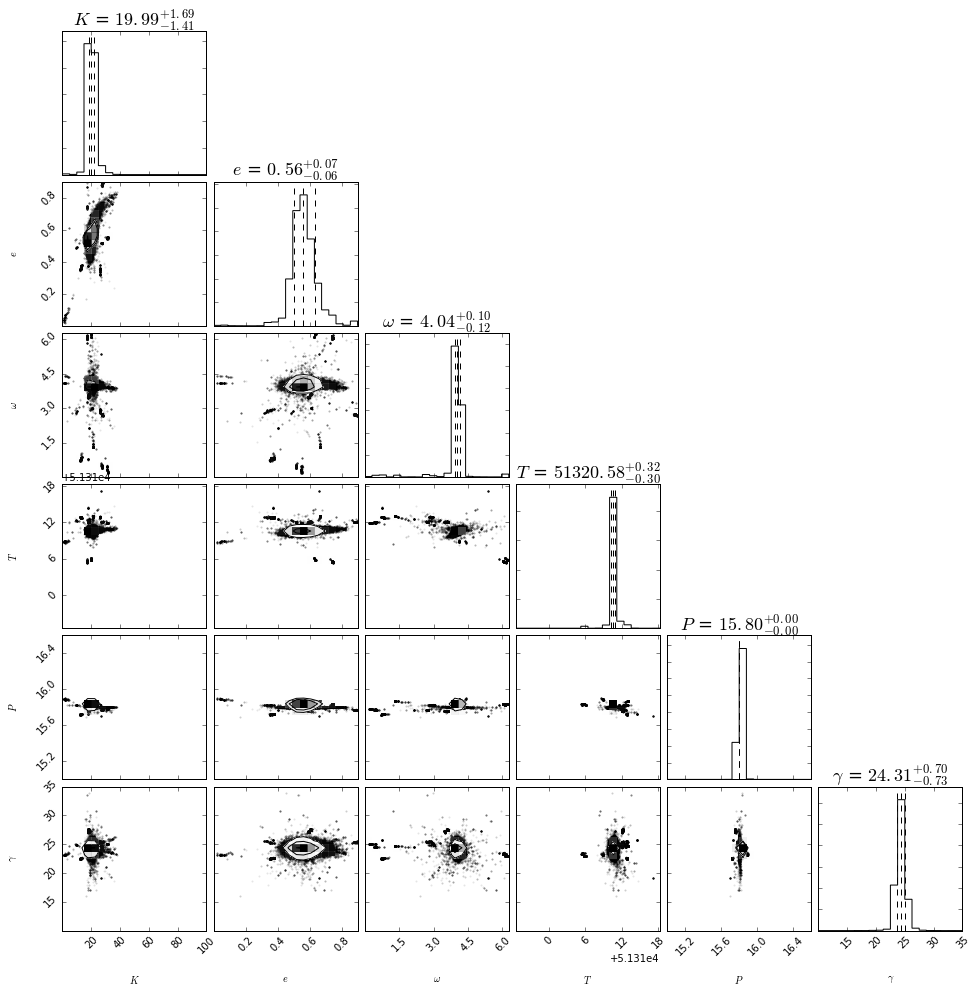

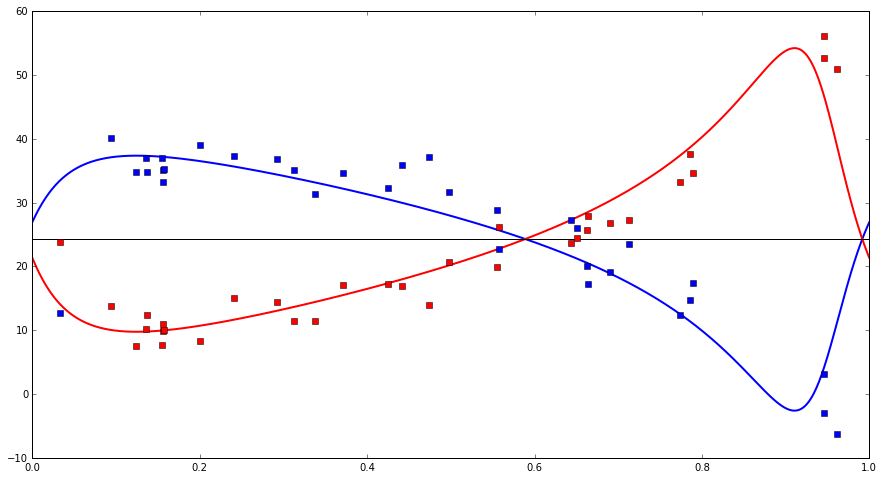

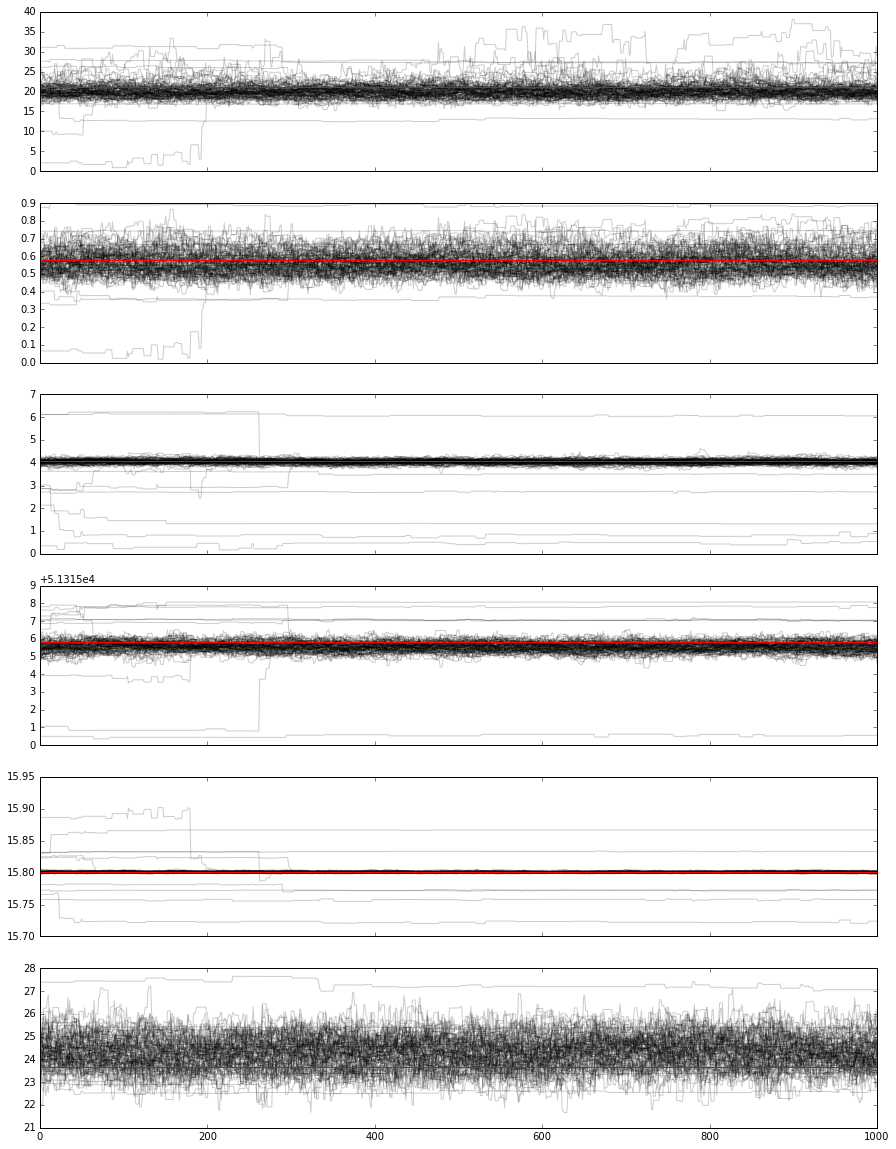

In [1]:
#this is pretty messy, I intend to go through and cleanup / annotate soon
#This code is built from the example found here: http://dan.iel.fm/emcee/current/user/line/#results
import time
t0 = time.time()
import numpy as np
import emcee
from matplotlib import pyplot as plt
import functions as f
import corner
%matplotlib inline
filename     = 'DQ Tau.tbl'
system       = np.genfromtxt(filename, skip_header=1, usecols=(0, 1, 2))
JD, RVp, RVs = [datum[0] for datum in system], [datum[1] for datum in system], [datum[2] for datum in system]
JDp, JDs     = JD, JD

periodogram = f.periodogram
dataWindow  = f.dataWindow
maxima      = f.maxima
phases      = f.phases
massRatio   = f.massRatio
adjustment  = f.adjustment
RV          = f.RV
residuals   = f.residuals
constraints = f.constraints
alteredRV   = f.alteredRV
initialGuess= f.initialGuess

for i in range(0, len(JD)-1):
    if np.isnan(system[i][1]):
        JDp, RVp = adjustment(JD, RVp)
        break
        
for i in range(0, len(JD)-1):
    if np.isnan(system[i][2]):
        JDs, RVs = adjustment(JD, RVs)
        break

mass_ratio = 0.898896068135

#constrain parameters
lower_bounds = [0, 0, 0, JD[0]+((JD[-1]-JD[0])/2)-0.75*15.8, 15, 10]
upper_bounds = [100, 0.9, 2*np.pi, JD[0]+((JD[-1]-JD[0])/2)+0.75*15.8, 16.6, 35]

#set dimensionality and walker number
ndim, nwalkers, nsteps = 6, 400, 10000

initial_guess = initialGuess(lower_bounds, upper_bounds, JDp, RVp)

def likelihood(parameters, mass_ratio, primary, secondary):
    r = np.sqrt(sum((np.asarray(primary)-RV(JDp, mass_ratio, parameters)[0])**2)
        +sum((np.asarray(secondary)-RV(JDs, mass_ratio, parameters)[1])**2))
    return -r

#function is poorly named, returns the negative infinity if parameters lie outside contraints, otherwise
#returns the output from residuals()
def probability(initial_guess, mass_ratio, RVp, RVs, lower, upper):
    con = constraints(initial_guess, lower, upper)
    if not np.isfinite(con):
        return -np.inf
    return con + likelihood(initial_guess, mass_ratio, RVp, RVs)



#initialize walkers 
position = [initial_guess + 0.1*np.random.randn(ndim) for i in range(nwalkers)]

#walkers distributed in gaussian ball around most likely parameter values
for i in range(0, nwalkers-1):
    position[i][0] = initial_guess[0] + 2.5*np.random.randn(1) #K
    position[i][1] = initial_guess[1] + 0.1*np.random.randn(1) #e
    position[i][2] = initial_guess[2] + 1  *np.random.randn(1) #w
    position[i][3] = initial_guess[3] +     np.random.randn(1) #T
    position[i][4] = initial_guess[4] +0.01*np.random.randn(1) #P
    position[i][5] = initial_guess[5] + 3  *np.random.randn(1) #y

#create the sampler object and do the walk
sampler = emcee.EnsembleSampler(nwalkers, ndim, probability,
                                args=(mass_ratio, RVp, RVs, lower_bounds, upper_bounds), threads = 4)
sampler.run_mcmc(position, nsteps)

#save the results of the walk
samples = sampler.chain[:, :, :].reshape((-1, ndim))
results = np.asarray(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                              zip(*np.percentile(samples, [16, 50, 84], axis=0)))))

#create the corner plot
fig = corner.corner(samples, labels=["$K$", "$e$", "$\omega$", "$T$", "$P$", "$\gamma$"],
                    extents=[[lower_bounds[0], upper_bounds[0]], [lower_bounds[1],upper_bounds[1]],
                             [lower_bounds[2], upper_bounds[2]],
                             [lower_bounds[3], upper_bounds[3]], [lower_bounds[4], upper_bounds[4]],
                             [lower_bounds[5], upper_bounds[5]]],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 18})
fig.savefig("parameter_results.png")

#create the curves plot
x = np.linspace(0, 15.8, num=nsteps)
fig, ax = plt.figure(figsize=(15,8)), plt.subplot(111)
#for K, e, w, T, P, y in samples[np.random.randint(len(samples), size=250)]:
#    parameters = K, e, w, T, P, y
#    primary, secondary = RV(x, mass_ratio, parameters)
#    ax.plot(x/parameters[4], primary, 'c', label='Potential Primary Curves', alpha=0.2)
#    ax.plot(x/parameters[4], secondary, 'm', label='Potential Secondary Curves', alpha=0.2)
primary, secondary = RV(x, mass_ratio, [results[0][0], results[1][0], results[2][0],
                                        results[3][0], results[4][0], results[5][0]])
ax.plot(x/results[4][0], primary, 'b', lw=2)
ax.plot(x/results[4][0], secondary, 'r', lw=2)
ax.plot(x, np.ones(len(x))*results[5][0], 'k' , label='Systemic Velocity')
ax.plot(phases(results[4][0], results[3][0], JDp), RVp, 'bs', label='Primary RV Data') #data phased to result period
ax.plot(phases(results[4][0], results[3][0], JDs), RVs, 'rs', label='Secondary RV data')
ax.set_xlim([0,1])
plt.savefig('curve_results.png')

#create the walkers plot
fig, ax = plt.subplots(6, 1, sharex='col')
for i in range(6):
    for j in range(len(sampler.chain[:, 0, i])):
        ax[i].plot(np.linspace(0, nsteps, num=nsteps-100), sampler.chain[j, 100:, i], 'k', alpha=0.2)
    ax[i].plot(np.linspace(0, nsteps, num=nsteps-100) , np.ones(nsteps-100)*initial_guess[i], 'r')
fig.set_figheight(20)
fig.set_figwidth(15)
plt.savefig('walk_results.png')

t = time.time()
print('Completed in ', int((t-t0)/60), ' minutes and ', int(((t-t0)/60-int((t-t0)/60))*60), 'seconds.')